<a href="https://colab.research.google.com/github/Ixiondbz/CSE499/blob/main/NEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install dependencies and 
!pip install albumentations==0.4.6
!pip install pycocotools --quiet

!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection

# Clone TorchVision repo and copy helper files
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0
%cd ..
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./


# basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd

# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# helper libraries
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

!apt-get install python3-openslide
from openslide import open_slide

import plotly.express as px

from torchvision.models.detection import FasterRCNN
from torch.utils.data import DataLoader, Dataset

     |████████████████████████████████| 117 kB 8.7 MB/s 
     |████████████████████████████████| 948 kB 59.8 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=9fd31998ebda277bba13edde26cb36a131750b9b9ddaa0a643ffb08a5138ea7b
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
Cloning into 'vision'...
remote: Enumerating objects: 87216, done.
remote: Counting objects: 100% (22347/22347), done.
remote: Compressing objects: 100% (1945/1945), done.
remote: Total 87216 (delta 20583), reused 21891 (delta 20284), pack

In [2]:
import json
from pathlib import Path

from google.colab import drive
drive.mount('/drive')

folder = "MyDrive/MIDOG_Challenge"
midog_folder = Path("/drive") / Path(folder)
print(list(midog_folder.glob("*.*")))

image_folder = Path("/content/drive/MyDrive/CSE499 Project/train_images")

hamamatsu_rx_ids = list(range(0, 51))
hamamatsu_360_ids = list(range(51, 101))
aperio_ids = list(range(101, 151))
leica_ids = list(range(151, 201))


annotation_file = midog_folder / "MIDOG.json"
rows = []

Mounted at /drive
[PosixPath('/drive/MyDrive/MIDOG_Challenge/MIDOG.sqlite'), PosixPath('/drive/MyDrive/MIDOG_Challenge/MIDOG.json')]


In [3]:
with open(annotation_file) as f:
    data = json.load(f)

    categories = {1: 'mitotic figure', 2: 'hard negative'}

    for row in data["images"]:
        file_name = row["file_name"]
        image_id = row["id"]
        width = row["width"]
        height = row["height"]

        scanner  = "Hamamatsu XR"
        if image_id in hamamatsu_360_ids:
            scanner  = "Hamamatsu S360"
        if image_id in aperio_ids:
            scanner  = "Aperio CS"
        if image_id in leica_ids:
            scanner  = "Leica GT450"
         
        for annotation in [anno for anno in data['annotations'] if anno["image_id"] == image_id]:
            box = annotation["bbox"]
            cat = categories[annotation["category_id"]]

            rows.append([file_name, image_id, width, height, box, cat, scanner])
        
df = pd.DataFrame(rows, columns=["file_name", "image_id", "width", "height", "box", "cat", "scanner"])

In [4]:
df[df['cat']=='hard negative'].index

Int64Index([   0,    1,    2,    3,    4,    7,   10,   11,   14,   15,
            ...
            4420, 4422, 4423, 4424, 4425, 4426, 4430, 4432, 4433, 4434],
           dtype='int64', length=2714)

In [5]:
df.drop(df[df['cat']=='hard negative'].index,inplace=True)

In [6]:
df

,file_name,image_id,width,height,box,cat,scanner
5,002.tiff,2,7215,5412,"[4397, 191, 4447, 241]",mitotic figure,Hamamatsu XR
6,002.tiff,2,7215,5412,"[1842, 1558, 1892, 1608]",mitotic figure,Hamamatsu XR
8,002.tiff,2,7215,5412,"[5319, 3252, 5369, 3302]",mitotic figure,Hamamatsu XR
9,002.tiff,2,7215,5412,"[6242, 3193, 6292, 3243]",mitotic figure,Hamamatsu XR
12,002.tiff,2,7215,5412,"[4636, 4294, 4686, 4344]",mitotic figure,Hamamatsu XR
...,...,...,...,...,...,...,...
4421,150.tiff,150,6467,4862,"[5373, 2398, 5423, 2448]",mitotic figure,Aperio CS
4427,150.tiff,150,6467,4862,"[3698, 3258, 3748, 3308]",mitotic figure,Aperio CS
4428,150.tiff,150,6467,4862,"[308, 4254, 358, 4304]",mitotic figure,Aperio CS
4429,150.tiff,150,6467,4862,"[553, 4394, 603, 4444]",mitotic figure,Aperio CS


In [7]:
dataset_1 = df[df['scanner']=='Hamamatsu XR']
dataset_2 = df[df['scanner']=='Hamamatsu S360']
dataset_3 = df[df['scanner']=='Aperio CS']
#dataset_4 = df[df['scanner']=='Leica GT450']

In [8]:
len(dataset_1['image_id'].unique())+len(dataset_2['image_id'].unique())+len(dataset_3['image_id'].unique())

135

In [8]:
image_folder = Path("/drive/MyDrive/CSE499 Project/train_images")

In [11]:
# img_id = 2
# thumbail_size_big = 1024
# slide = open_slide( str(image_folder / f"{img_id:03d}.tiff") )

# image = slide.get_thumbnail((1443, 1082))

# fig = px.imshow(image)

# scale_x = slide.level_dimensions[0][0] / image.size[0]
# scale_y = slide.level_dimensions[0][1] / image.size[1]

# for id, anno in dataset_1[dataset_1["image_id"] == img_id].iterrows():

#     x0, y0, x1, y1 = anno.box[0] / scale_x, anno.box[1] / scale_y, anno.box[2] / scale_x, anno.box[3] / scale_y


#     fig.add_shape(
#         type='rect',
#         x0=x0, x1=x1, y0=y0, y1=y1,
#         xref='x', yref='y',
#         line_color='red' if "mitotic" in anno["cat"] else "blue"
#     )

# fig.update_layout(
#     autosize=False,
#     width=image.size[0],
#     height=image.size[1],
#     )

# fig.show()    

In [9]:
DataFrame = pd.read_pickle('/drive/MyDrive/CSE499 Project/Patch Datasets/Hamamatsu S360/DataFrame.pkl')

In [10]:
df_hamamatsu_xr =  pd.read_pickle('/drive/MyDrive/CSE499 Project/Patch Datasets/Hamamatsu XR/DataFrame.pkl')
df_hamamatsu_s360 =  pd.read_pickle('/drive/MyDrive/CSE499 Project/Patch Datasets/Hamamatsu S360/DataFrame.pkl')
#df_aperio_cs =     pd.read_pickle('/drive/MyDrive/CSE499 Project/Patch Datasets/Aperio CS/DataFrame.pkl')


In [11]:
for i in range(541):
  xmin,ymin,xmax,ymax = DataFrame.box[i]
  if xmin>=xmax or ymin>=ymax:
    print(i)
    break

In [30]:
class MitosisImagesDataset(torch.utils.data.Dataset):
  def __init__(self, files_dir, width, height,transforms=None):
    self.transforms = transforms
    self.files_dir  = files_dir
    self.height     = height
    self.width      = width

    self.imgs = [image for image in sorted(os.listdir(files_dir)) if image[-5:]=='.tiff']
    
    self.classes = [_, 'mitotic figure']

  def __getitem__(self, idx):
    img_name   = self.imgs[idx]
    image_path = os.path.join(self.files_dir, img_name)

    img     = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)

    img_res /= 255.0
    
    dataframe = df_hamamatsu_s360[df_hamamatsu_s360['file_name']==img_name].copy()
    
    boxes = []
    labels = []

    wt = img.shape[1]
    ht = img.shape[0]
    
    for index in dataframe.index:
      labels.append(1)
      
      List = dataframe['box'][index]
      
      scale_x = 7215/self.width
      scale_y = 5412/self.height

      xmin = List[0]#/scale_x
      xmax = List[2]#/scale_x
      ymin = List[1]#/scale_y
      ymax = List[3]#/scale_y
        
      xmin_corr = (xmin)
      xmax_corr = (xmax)
      ymin_corr = (ymin)
      ymax_corr = (ymax)
          
      boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
    


    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype=torch.int64)
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    #area = torch.as_tensor(area, dtype=torch.float32)
    iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
    
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = torch.tensor([idx])
    target["area"] = area
    target["iscrowd"] = iscrowd
    
    if self.transforms:
      sample = self.transforms(image = img_res,
                                bboxes = target['boxes'],
                                labels = labels)
      img_res = sample['image']
      target['boxes'] = torch.Tensor(sample['bboxes'])

    return img_res, target
    
  def __len__(self):
    return len(self.imgs)

In [13]:
# Function to visualize bounding boxes in the image
def plot_img_bbox(img, target):
  # plot the image and bboxes
  # Bounding boxes are defined as follows: x-min y-min width height
  fig, a = plt.subplots(1,1)
  fig.set_size_inches(5,5)
  a.imshow(img)
  for box in (target['boxes']):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 2,
      edgecolor = 'r',
      facecolor = 'none'
    )
    # Draw the bounding box on top of the image
    a.add_patch(rect)
  plt.show()

In [14]:
# Send train=True for training transforms and False for val/test transforms
def get_transform(train):
  if train:
    return A.Compose(
      [
        A.HorizontalFlip(0.5),
        # ToTensorV2 converts image to pytorch tensor without div by 255
        ToTensorV2(p=1.0) 
      ],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )
  else:
    return A.Compose(
      [ToTensorV2(p=1.0)],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )

In [15]:
files_dir = '/drive/MyDrive/CSE499 Project/Patch Datasets/Hamamatsu XR'
test_dir = '/drive/MyDrive/CSE499 Project/Patch Datasets/Hamamatsu S360'

In [19]:
dataset =      MitosisImagesDataset(files_dir, 481, 451)
dataset_test = MitosisImagesDataset(test_dir, 481, 451)

In [ ]:
target

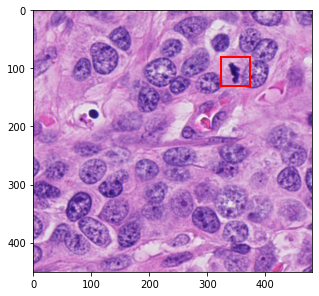

In [20]:
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[115]
plot_img_bbox(img, target)

In [21]:
train_dataset =      MitosisImagesDataset(files_dir, 481, 451,transforms=get_transform(train=True))

def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader  = DataLoader(train_dataset,batch_size=15,shuffle=True,num_workers=4,collate_fn=utils.collate_fn)

In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [23]:
device

device(type='cuda')

In [ ]:
# from matplotlib import pyplot as plt 

# images,targets = next(iter(train_data_loader))
# images = list(image.to(device) for image in images)
# targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

# boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
# img = images[0].permute(1,2,0).cpu().numpy()
# fig,ax = plt.subplots(1, 1, figsize=(50,30))

# for box in boxes:
#   cv2.rectangle(img,
#                 (box[0],box[1]),
#                 (box[2],box[3]),
#                 (220,0,0), 1)

# ax.set_axis_off()
# ax.imshow(img)

In [24]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes=2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [25]:
model = model.to(device)

In [26]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 10

In [ ]:
# itr = 1

# for epoch in range(num_epochs):
#   for images,targets in train_data_loader:
#     images = list(image.to(device) for image in images)
#     targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

#     loss_dict = model(images,targets)

#     losses = sum(loss for loss in loss_dict.values())
#     loss_value = losses.item()

#     optimizer.zero_grad()
#     losses.backward()
#     optimizer.step()

#     if itr % 50 == 0:
#       print(f"Iteration #{itr} loss: {loss_value}")

#     itr+=1

#     lr_scheduler.step()

#   print(f"Epoch #{epoch} loss: {loss_value}")

In [27]:
num_epochs = 50

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    #evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/100]  eta: 0:14:37  lr: 0.000055  loss: 1.5314 (1.5314)  loss_classifier: 1.1088 (1.1088)  loss_box_reg: 0.0240 (0.0240)  loss_objectness: 0.3750 (0.3750)  loss_rpn_box_reg: 0.0236 (0.0236)  time: 8.7753  data: 6.3029  max mem: 11439
Epoch: [0]  [ 10/100]  eta: 0:05:38  lr: 0.000560  loss: 0.8151 (0.8465)  loss_classifier: 0.4794 (0.5509)  loss_box_reg: 0.0283 (0.0328)  loss_objectness: 0.2357 (0.2395)  loss_rpn_box_reg: 0.0236 (0.0234)  time: 3.7666  data: 1.7811  max mem: 11702
Epoch: [0]  [ 20/100]  eta: 0:03:51  lr: 0.001065  loss: 0.3250 (0.5900)  loss_classifier: 0.1540 (0.3579)  loss_box_reg: 0.0536 (0.0538)  loss_objectness: 0.0881 (0.1590)  loss_rpn_box_reg: 0.0174 (0.0193)  time: 2.6057  data: 0.6894  max mem: 11702
Epoch: [0]  [ 30/100]  eta: 0:03:01  lr: 0.001569  loss: 0.3135 (0.4934)  loss_classifier: 0.1487 (0.2875)  loss_box_reg: 0.0868 (0.0669)  loss_objectness: 0.0562 (0.1239)  loss_rpn_box_reg: 0.0097 (0.0152)  time: 1.9364  data: 0.0488  max mem: 11

KeyboardInterrupt: ignored

In [28]:
%cd '/drive/MyDrive/CSE499 Project/modelSaves'

/drive/.shortcut-targets-by-id/1M-kTVs7g43FucvCjcPvKwiR8r1e1qtHe/CSE499 Project/modelSaves


In [29]:
torch.save(model.state_dict(), 'model.pth')

torch.save({
'epoch':epoch,
'model_state_dict':model.state_dict(),
'optimizer_state_dict':optimizer.state_dict(),
},'ckpt.pth')

In [31]:
test_dataset = MitosisImagesDataset(test_dir, 481, 451,transforms=get_transform(train=False))

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

test_split = 0.2
tsize = int(len(test_dataset)*test_split)

test_dataset = torch.utils.data.Subset(test_dataset, indices[-tsize:])

test_data_loader = torch.utils.data.DataLoader(
  test_dataset,
  batch_size=15,
  shuffle=False,
  num_workers=4,
  collate_fn=utils.collate_fn,
)

In [ ]:
evaluate(model, test_data_loader, device=device)

creating index...
index created!
Test:  [ 0/25]  eta: 0:00:47  model_time: 0.8671 (0.8671)  evaluator_time: 0.0100 (0.0100)  time: 1.8954  data: 1.0025  max mem: 11702
Test:  [24/25]  eta: 0:00:00  model_time: 0.8462 (0.8439)  evaluator_time: 0.0087 (0.0090)  time: 0.9095  data: 0.0471  max mem: 11702
Test: Total time: 0:00:23 (0.9498 s / it)
Averaged stats: model_time: 0.8462 (0.8439)  evaluator_time: 0.0087 (0.0090)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.408
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.627
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.496
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.410
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ 

In [34]:
!ls -al

total 72
drwxr-xr-x 1 root root  4096 Feb  5 06:17 .
drwxr-xr-x 1 root root  4096 Feb  5 06:14 ..
-rw-r--r-- 1 root root 11984 Feb  5 06:12 coco_eval.py
-rw-r--r-- 1 root root  8732 Feb  5 06:12 coco_utils.py
drwxr-xr-x 4 root root  4096 Feb  1 14:31 .config
drwx------ 5 root root  4096 Feb  5 06:17 drive
-rw-r--r-- 1 root root  3746 Feb  5 06:12 engine.py
drwxr-xr-x 2 root root  4096 Feb  5 06:12 __pycache__
drwxr-xr-x 1 root root  4096 Feb  1 14:32 sample_data
-rw-r--r-- 1 root root  1534 Feb  5 06:12 transforms.py
-rw-r--r-- 1 root root  9161 Feb  5 06:12 utils.py
drwxr-xr-x 7 root root  4096 Feb  5 06:12 vision


In [ ]:
model.load_state_dict(torch.load('./model.pth'))
model = model.to(device)

In [32]:
def apply_nms(orig_prediction, iou_thresh=0.3):
  keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
  
  final_prediction = orig_prediction
  final_prediction['boxes'] = final_prediction['boxes'][keep]
  final_prediction['scores'] = final_prediction['scores'][keep]
  final_prediction['labels'] = final_prediction['labels'][keep]
  
  return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
  return torchtrans.ToPILImage()(img).convert('RGB')

In [35]:
test_dir = '/drive/MyDrive/CSE499 Project/Patch Datasets/Hamamatsu S360'

In [36]:
test_dataset = MitosisImagesDataset(test_dir, 481, 451, transforms = get_transform(train=False))
dataset      = MitosisImagesDataset(test_dir, 481, 451)

Predicted labels

MODEL OUTPUT



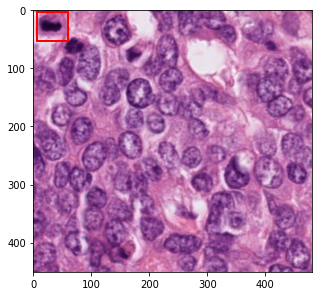

In [40]:
# pick one image from the test set
img, target = test_dataset[201]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
  prediction = model([img.to(device)])[0]
    
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction,iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction)

Ground Truth labels

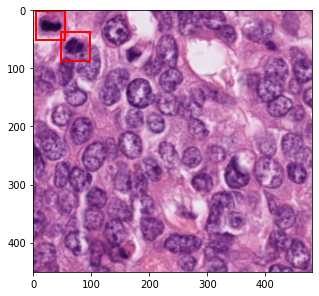

In [41]:
img, target = dataset[201]
plot_img_bbox(img, target)

In [43]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [44]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


total 4
dr-x------ 5 root root 4096 Mar 28  2021 MIDOG_Challenge/
